In [1]:
import csv
import io
import pandas as pd
import os
from tensorflow import expand_dims as expand_dimsTF
from skimage.metrics import structural_similarity as ssimSKI
from PIL import Image
import numpy as np
from scripts import commonUtils as alex
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda
import tensorflow as tf
from scripts import commonUtils as alex
from modelli import modelli
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2025-01-28 05:40:44.985935: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 05:40:45.007467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 05:40:45.007486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 05:40:45.007491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 05:40:45.011748: I tensorflow/core/platform/cpu_feature_g

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


2025-01-28 05:40:45.971927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 05:40:45.983997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 05:40:45.984119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<div align="center">

# Progetto di Machine Learning  
### Traccia T8  


**di Alexandru Nazare**  
**Matricola: 0365256**  


### Anno Accademico 2024/2025  

</div>


---
<div align="center">

# Table of Contents  
**Progetto di Machine Learning - Traccia T8**

</div>

---

1. **Introduzione**  
   - Dataset
      - Dataset preprocessing
      - Dataset for training
   - Loss function and training

2. **Approcci utilizzati**  
   - Dataset utilizzato  
   - Preprocessing dei dati  

3. **Soluzioni proposte**  
   - Modello BW RGB
   - Modello  RGB 

4. **Risultati**  
 
---

## 1. Introduzione <a  id="intro"></a>

La traccia **T8**, con titolo *"Compressione di immagini tramite Autoencoder"*, propone la seguente descrizione:  

> "Addestrare un autoencoder per la compressione di immagini di fiori, utilizzando il dataset `102flowers.zip`. Confrontare le prestazioni del modello (e sue eventuali varianti) su un sottoinsieme di immagini di validazione, in termini di rapporto di compressione e qualità di ricostruzione dell’immagine."  

Inoltre, per quanto riguarda la valutazione delle prestazioni, la traccia specifica:  

> "Per valutare la qualità delle immagini ricostruite, si suggerisce di utilizzare lo **Structural Similarity Index Measure (SSIM)** (implementazioni per Tensorflow facilmente reperibili). Confrontare il modello anche con le immagini compresse utilizzando il formato **JPEG**, con diverse configurazioni per il quality factor."  

Ora, definito l'obiettivo di questo progetto, desidero innanzitutto illustrare alcune difficoltà e scelte che ho dovuto affrontare durante l'ideazione delle mie soluzioni. In particolare, approfondirò i seguenti aspetti:  

- Le sfide legate al **dataset**  
- L'implementazione e l'utilizzo della funzione **SSIM**  
- L'approccio adottato per affrontare la tematica della **compressione** nel contesto dell'**Autoencoder**  


## 1.1 Dataset <a  id="datasetIntro"></a>
Per quanto riguarda il **dataset**, ci troviamo davanti a una collezione di circa **8200 immagini di fiori**. Il nome `102flowers` potrebbe suggerire la presenza di **102 specie** (o forse il numero di categorie con cui possono essere etichettati).  

Il dataset è molto ampio e variegato, sebbene in alcune istanze sembri che lo stesso fiore sia stato fotografato da angolazioni differenti.  

Eseguendo le seguenti istruzioni in Python, è possibile visualizzare tre statistiche minimali ma importanti sul dataset:  

In [2]:
from scripts import commonUtils as alex
alex.checkSizeOfset("102flowers/")

(8.16, (500, 500), (1024, 1168))

La prima **8.16** indica, in GB, quanto il dataset occuperebbe in formato "raw". Le altre due statistiche invece indicano rispettivamente la **dimensione massima** e **minima** dell'altezza e della larghezza delle immagini. Come si può notare, le immagini hanno un range di dimensioni **molto ampio**.


### 1.1.1 Dataset preprocessing <a id="scelteDataset"></a>
Il primo argomento da affrontare è come processare questi dati affinché possano essere utilizzati in un **autoencoder**. Sebbene teoricamente sia possibile utilizzare del **preprocessing** e **postprocessing** per usare le immagini nelle loro dimensioni originarie (in particolare aggiungendo e togliendo **padding**), ho preferito utilizzare una **dimensione standard** per tutte le immagini per vari motivi:

- Facilitarmi il lavoro
- Facilitare il training, sia a livello **computazionale** che in termini di **memoria utilizzata**
- Standardizzare il livello di compressione, evitando di penalizzare le immagini più piccole, dato che le immagini residue avrebbero avuto tutte la stessa dimensione.

Inizialmente avevo optato per una dimensione di **500x500**, ma durante il training ho riscontrato difficoltà a causa dell'alta necessità di memoria. SI poteva ovviare al problema diminuendo la grandezza dei **mini-batch** e effettuando un training in più fasi, ma ciò avrebbe aumentato i tempi di allenamento e la complessità della soluzione. Inoltre, sarebbe stato particolarmente problematico per una meccanica che spiegherò più avanti, la quale richiede l'allenamento doppio per ogni modello.

Pertanto, ho deciso di optare per una dimensione di **100x100 RGB**, che introduce molto **rumore** nelle immagini a causa dei dettagli che vengono ridotti o sovrapposti. Tuttavia, questo non cambia l'obiettivo del progetto. Anzi, mi permette di effettuare più esperimentazioni senza dovermi preoccupare dei **tempi di training** o dei problemi legati alla dimensione del dataset.

In seguito, illustrerò come i modelli che ho realizzato si comportano anche su immagini di dimensioni maggiori, applicando alcune restrizioni al training.




Per effettuare il resizing delle immagini ho usato la seguente funzione che ho reallizzato(per vedere l'implementazione vedere il file scripts/commonUtils.py):

In [4]:
alex.resizeImages("pathfarlocco","nuovopathfarlocco",(100,100),overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'pathfarlocco'

Una volta ridimensionato il data set ottengo le seguenti informazioni utilizzando la stessa funzione di prima:

In [6]:
alex.checkSizeOfset("images100/")

(0.24, (100, 100), (100, 100))

Quindi, riducendo notevolmente lo spazio necessario in memoria, protando da  **8 GB** ad appena **0.2 GB** e standardizzando le dimensioni.
Inoltre e' stata creata anche una versione del dataset per le dimensioni **300x300 RGB**.

In [7]:
alex.checkSizeOfset("images300/")

(2.21, (300, 300), (300, 300))

### 1.1.2 Dataset for Training <a id="trainingDataset"></a>

Ho realizzato una classe `getSamples` nel file `commonUtils` per la gestione del dataset, sfruttando `keras.utils.image_dataset_from_directory` per dividere il dataset in **validation set** e **training set**. Questa classe si è rivelata utile anche per effettuare il training in più fasi, suddividendo il training set in diversi batch quando necessario.  

Per quanto riguarda il **test set**, ho prelevato l'1% del dataset e l'ho messo da parte nella cartella `testSet`, insieme ad alcune immagini prese casualmente da internet a scopo di test.

Ogni volta che ottengo un batch tramite il metodo `getBatch` della classe `getSamples`, ottengo un array di tipo `numpy` composto da tutte le immagini del batch, trasformate in array di dimensione **100x100xc** (dove `c` rappresenta il numero di canali). In alternativa, posso ottenere un array "flattened" se richiesto.  

Successivamente, divido i valori per **255** per portarli nel range **[0,1]** e rimuovo il canale alpha, se presente.



## 1.2 Funzione loss e training <a  id="lossAndTaining"></a>
### 1.2.1 Funzione loss <a  id="loss"></a>

Per quantificare la **similarità** tra immagini originali e immagini compresse e poi decompresse, ho scelto di utilizzare la **Structural Similarity Index Measure (SSIM)**. Questo indice è generalmente utilizzato per immagini in bianco e nero, ma trattando ogni canale individualmente e poi calcolando la media del valore di ciascun canale, si ottiene un valore indicativo abbastanza affidabile, anche se non al 100%.  

Infatti, in alcune situazioni, specialmente valutando la compressione in formato JPEG, immagini con buoni valori di SSIM non risultavano visivamente simili a occhio umano. Il SSIM produce un valore compreso tra **[0,1]**, dove un valore alto indica una buona somiglianza.

Per la funzione di **loss**, ho scelto di utilizzare una **loss custom** composta da **MSE** e **SSIM** (`loss_ssim = 1 - ssim`). Sebbene entrambe le metriche funzionassero bene, in particolare la MSE, ho deciso di utilizzare una combinazione:  

```python
loss = mse * (1 + ssim)
```
Questa combinazione dà priorità alla MSE. In questo modo, ho osservato che riesco a raggiungere risultati migliori.

### 1.2.1 Training <a  id="training"></a>
Per quanto riguarda il **training**, ho scelto di non utilizzare forme di regolarizzazione per i seguenti motivi:

- Osservando i parametri attraverso **TensorBoard**, ho notato che raramente assumono valori elevati. Per questo motivo, ho deciso di non utilizzare regolarizzazioni relative ai pesi.
- Vista la natura **unsupervised** del problema e la struttura delle soluzioni adottate, non ho rilevato segni di **overfitting**. Anzi, introducendo immagini completamente estranee al dataset nel test set, ho osservato che la soluzione riusciva ad adattarsi anche a queste.
- Utilizzando pochi **fully connected layers**, ho trovato poco utile l'applicazione del **dropout** ai layer convoluzionali.

L'unica forma di regolarizzazione che ho utilizzato durante i processi di training è l' **early-stopping**, che si è rivelato utile per risparmiare tempo.

Per tutte le fasi di **training**, ho utilizzato l'ottimizzatore **Adam** con un learning rate scelto tramite il tuning di **Keras-Tuner**, che si è rivelato essere il valore di default: **0.001**. Ho provato ad utilizzare altri ottimizzatori, ma questi richiedevano molte più epoche per raggiungere la convergenza (ad esempio, **RMSProp**).

Per il **validation set**, ho prelevato una piccola parte del training set, in modo da poter misurare l'errore su di esso e utilizzarlo per l'**early-stopping**.

Ho anche tentato di effettuare operazioni di **clustering** per dividere il dataset in classi e bilanciare i mini-batch e i vari set, ma senza successo. Ho utilizzato sia modelli di clustering tradizionali che modelli pre-addestrati come **VGG16** (con un minimo di transfer learning). Tuttavia, non sono riuscito a ottenere risultati significativi.

Nella seguente immagine ottenuta attraverso l'utilizzo di **k-mean** e **PCA**, ogni riga rappresenta un cluster con alcuni valori sample associati. Il numero di cluster è stato scelto tramite il **silhouette score**, senza però produrre risultati notevoli, se non in casi specifici come il dente di leone o altri fiori con colori gialli (che però non sono riuscito a catturare nell'immagine).

![Esempio di clustering](utilsImage/kmean.jpg)


## 2. Approcci Utilizzati <a id="intro"></a>

Per la scelta degli approcci, è necessario considerare due fattori:  
- **Accuratezza della ricostruzione**: misurata sotto forma di **SSIM**.  
- **Compression rate ottenuto**: misurato attraverso il **byte rate**, calcolato come `bytes / (pixels * 3)`, dove il fattore `3` rappresenta i tre canali RGB.(valori bassi indicano una forte compressione del immagine)

L'accuratezza è difficile da ottenere, specialmente mantenendo il numero di parametri ristretto, ma il **byte rate** risulta ancora più complesso da ottimizzare.  

Infatti, anche riducendo un'immagine **100x100x3** a un residuo **50x50x3** con un **SSIM ≈ 1** dopo la ricostruzione, in condizioni normali avremmo un tensore **50x50x3 float32**, che produrrebbe:



In [8]:
print("byterate per tensore float di un modello con ssim=1 :"+str(50*50*3*4/(100*100*3)))
print("byterate immagine raw che utilizza un uint per ogni canale di  un pixel :"+str(100*100*3*1/(100*100*3)))

byterate per tensore float di un modello con ssim=1 :1.0
byterate immagine raw che utilizza un uint per ogni canale di  un pixel :1.0


Quindi, per ottenere un vantaggio rispetto al conservare un'immagine in formato raw, è necessario utilizzare meno di **$50 \times 50 \times 3$** float32 per rappresentare il residuo.  

Ho provato a utilizzare un'approssimazione di una **PCA** attraverso un **autoencoder** con layer densi. Nel **encoder**, il numero di unità nascoste corrisponde al numero di vettori della base della PCA, mentre nel **decoder** corrisponde al numero di **pixel × 3** dell'input.  

Utilizzando una base di dimensione **$30 \times 30 \times 3$**, ottengo che è necessario:


In [9]:
mem_parametri=(30*30*3)*(100*100*3)*2*4/(pow(10,9))
mem_fp=256*(30*30*3*4)/(pow(10,9))
mem_dati=256*(100*100*3*4)/(pow(10,9))
print("gb di parametri:"+str(mem_parametri))
print("gb per forward pass+dati :"+str(mem_fp+3*mem_dati))
print("gb per adam+gradienti :"+str(mem_parametri*3))

gb di parametri:0.648
gb per forward pass+dati :0.0949248
gb per adam+gradienti :1.944


Più o meno **3 GB**, rendendo il modello non trainabile sul mio PC. Potrei ridurre il numero di unità della base o passare a **float16**, ma comunque la **PCA** non produce risultati soddisfacenti.  

Utilizzando modelli preesistenti per implementare la PCA utilizzando la cpu invece della gpu(sfruttando la ram), ho ottenuto il seguente risultato:

![Esempio di PCA](utilsImage/pca.png)


Altri approcci che utilizzano i dense layer o comunque che producono resuidi di tensori float come compressione mi hanno portato a risultati simili con SSIM molto bassi quindi non gli elenco.

### 2.2 Upscaling <a id="upscaling"></a>

Per mantenere una compressione con un byte rate per pixel basso, ho cercato di rappresentare il residuo come immagine, quindi come un tensore di interi, per poi comprimerlo ulteriormente utilizzando **JPEG**. Questo permette di conservarlo, riaprirlo successivamente e passarlo al decoder per ricostruire l'immagine originale.  

Per realizzare ciò, ho utilizzato un encoder basato su layer convoluzionali in grado di ricavare una rappresentazione più compatta dell'immagine. Questa rappresentazione viene quindi passata al decoder, che, attraverso convoluzioni con stride frazionario (o operazioni inverse della convoluzione) e una serie di ulteriori convoluzioni, ricostruisce l'immagine originale con un buon tasso di qualità.  

### 2.2.1 Problema <a id="upscaling-problem"></a>

Il decoder produce un tensore di tipo **float**, che deve essere convertito in interi a 8 bit per poter essere salvato come immagine. Successivamente, questo tensore deve essere riconvertito in **float** per essere fornito nuovamente al decoder. Tuttavia, questa operazione non può essere effettuata durante il training per diversi motivi:

- Nei layer di casting, il gradiente risulta zero, bloccando di fatto l'intero processo di training. Potrei ignorare quel livello durante il calcolo del gradiente, ma ciò non risolverebbe comunque il problema.  
- Potrei svolgere il training normalmente e dopo aggiungere un layer sia al encoder che decoder che permette di fare il casting nelle due direzioni, ma questo produce risultati orribili siccome l'informazione che si perde con la conversione era necessaria dal decoder per per ricostruire l'immagine come aveva "imparato".
- Ho provato a introdurre del **noise** durante il training nell'ultimo layer dell'encoder, per poi inserire il layer di casting a training concluso. L'idea era di adattare la quantità di informazione persa con il casting al rumore introdotto durante il training. Tuttavia, questa soluzione non ha funzionato.  
  Una piccola variazione di un valore float, propagandosi attraverso tutti i pesi del modello, causava cambiamenti significativi nei risultati finali. Questo effetto era particolarmente evidente poiché i piccoli cambiamenti casuali iniziali (noise) venivano amplificati e, in seguito, assumevano una natura completamente diversa rispetto a quella prevista.

### 2.2.2 Strategia di risoluzione <a id="Strategia"></a>

Per risolvere il problema della conversione da **float** a **intero** descritto in precedenza, ho adottato la seguente strategia, che può essere considerata una sorta di pretraining non supervisionato per il decoder:

1. **Progettazione iniziale del modello**  
   - Ho progettato il modello normalmente, senza preoccuparmi del problema della conversione ad intero. La rappresentazione dell'immagine residua generata dall'encoder viene mantenuta come tensore di **float**.

2. **Addestramento iniziale del modello**  
   - Una volta ottenuto un valore della loss sufficientemente buono, il decoder ha imparato una rappresentazione efficace per il suo input.

3. **Costruzione di un nuovo modello**  
   - Ho costruito un nuovo modello che riutilizza l'encoder e il decoder del modello precedente:
     - All'**encoder** ho aggiunto un layer per la conversione da **float** a intero.  
     - Ho creato un modello di supporto, chiamato **converter**, che include un layer dedicato esclusivamente alla conversione da **float** a intero.  
     - Il **decoder** è rimasto invariato.  

4. **Congelamento e ulteriore addestramento**  
   - Ho congelato i pesi dell'encoder. Il flusso computazionale del nuovo modello è il seguente:  
     `input → encoder → immagine residua → converter → decoder → output`.  
   - Ho quindi eseguito un nuovo training su questo modello. Durante questa fase, il gradiente si ferma al decoder, che impara a lavorare sulla rappresentazione corretta del proprio input, tenendo conto della conversione effettuata dal layer di casting.

Facendo così, ottengo un modello che mi permette di sfruttare la strategia che intendo adottare:

- **Riduzione della dimensione dell'immagine**  
   - L'immagine viene compressa utilizzando una rete convoluzionale per ridurne le dimensioni.  

- **Salvataggio dell'immagine compressa**  
   - L'immagine risultante viene salvata come file **JPEG** (con `quality=100`).

- **Decodifica e ricostruzione**  
   - Quando necessario, l'immagine compressa viene recuperata e passata al decoder, che ricostruisce l'immagine originale.

Potevo evitare l'uso del **JPEG** e conservare direttamente il tensore, magari effettuando qualche operazione di riduzione ulteriore, se necessario. Tuttavia, per ora, mi sono limitato a questo approccio.


# 3. Soluzioni proposte <a id="Soluzioni proposte"></a>
Propongo due modelli, entrambi basati su reti convoluzionali e implementati seguendo la strategia descritta in precedenza.

## 3.1 Modello BW RGB
L'idea iniziale di questo modello era di utilizzare due immagini residuali prodotte dall'encoder:  
- Una immagine contenente informazioni relative alla **struttura** dell'immagine, utilizzando un solo canale.  
- Una immagine contenente informazioni relative ai **colori**, che utilizza tutti i canali.  

L'obiettivo era di favorire, in termini di dimensioni, l'immagine riguardante la struttura. Successivamente, queste due immagini sarebbero state combinate utilizzando:  
- Blocchi simili ad **Inception**.  
- Connessioni **residuali** tra i livelli e il primo residuo.

Entrambi gli approcci, però, si sono rivelati difficili da implementare in modo da ottenere risultati significativi. Di conseguenza, mi sono fermato a un compromesso che fornisce risultati apprezzabili.

### Versioni del modello
Propongo il modello in due versioni:  
1. **Prima versione**:  
   - Residuo relativo alla struttura: dimensioni $50 \times 50 \times 1$.  
   - Residuo relativo ai colori: dimensioni $50 \times 50 \times 3$.  

2. **Seconda versione**:  
   - Residuo relativo alla struttura: dimensioni $50 \times 50 \times 1$.  
   - Residuo relativo ai colori: dimensioni $25 \times 25 \times 3$.  

La seconda versione favorisce un **bit rate** più basso al costo di una **SSIM** leggermente inferiore.

### Risultati e struttura
Di seguito presento la struttura della **prima versione** del modello con i risultati delle compressioni. Per la **seconda versione**, tutte le informazioni sono disponibili nella cartella dedicata ai modelli.  
Inoltre, in seguito presentero dei grafici relativi ad entrambe le versioni.


In [10]:

testPool=alex.getSamples("testSet",imgSize=(100,100),batchSize=99999,seed=1,split=0.0)          
batch=testPool.getBatch(reshae=False)
#le linee di codice qui sopra servono solo per inizializzare i dati che andro ad usare 
model_BW_RGB_50=modelli.AutoencoderFinal(modelli.Autoencoder())
model_BW_RGB_50(batch[:5])                                                                  #necessario per caricare il modello
model_BW_RGB_50.load_weights('modelli/BN-RGB-50-RETRAIN.h5')
model_BW_RGB_25=modelli.AutoencoderFinal(modelli.Autoencoder(4),4) ## 4  serve per indicare che si sta utilizzando la seconda versione del modello  
model_BW_RGB_25(batch[:5])
model_BW_RGB_25.load_weights('modelli/BN-RGB-25-RETRAIN.h5')


Found 86 files belonging to 1 classes.


2025-01-28 05:40:56.858575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 05:40:56.858823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-28 05:40:56.858972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

86   86
got another batch,  0  remaning  we are using  86


2025-01-28 05:40:57.617696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


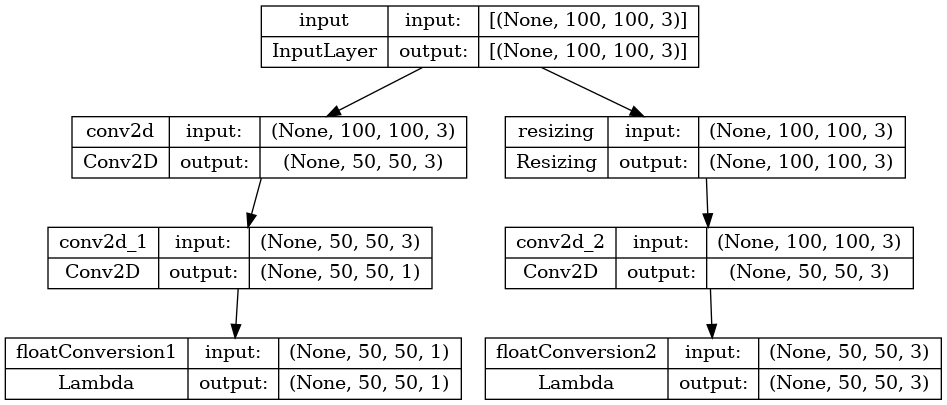

In [11]:
tf.keras.utils.plot_model(model_BW_RGB_50.encoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)



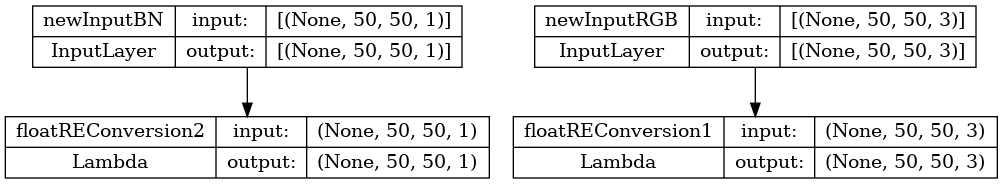

In [12]:
tf.keras.utils.plot_model(model_BW_RGB_50.converter, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)


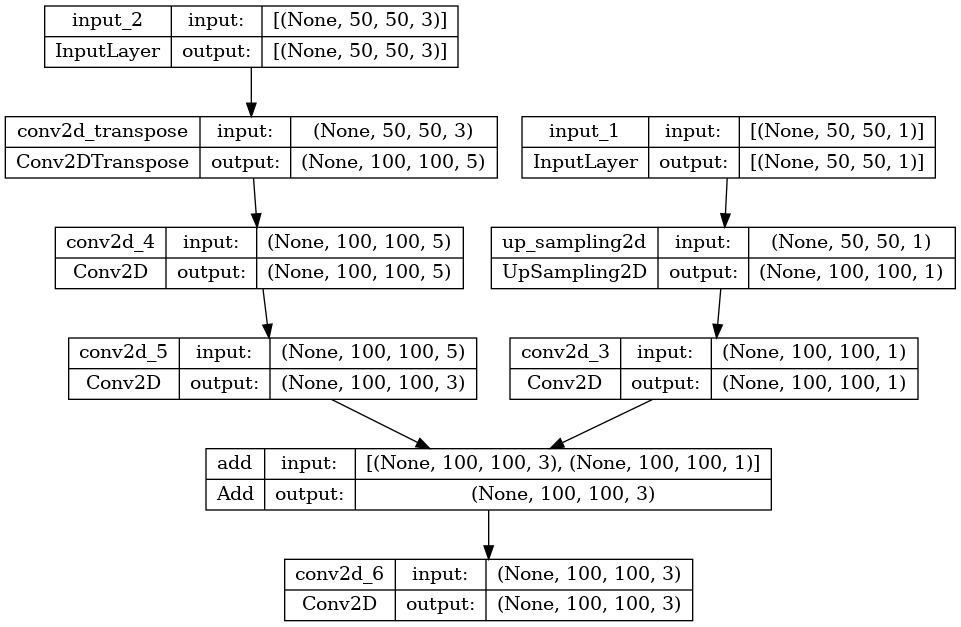

In [13]:
tf.keras.utils.plot_model(model_BW_RGB_50.decoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14280304..1.0481478].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29062662..1.1786659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.052821025..1.0613024].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04517796..1.0819635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.117658824..0.96241987].


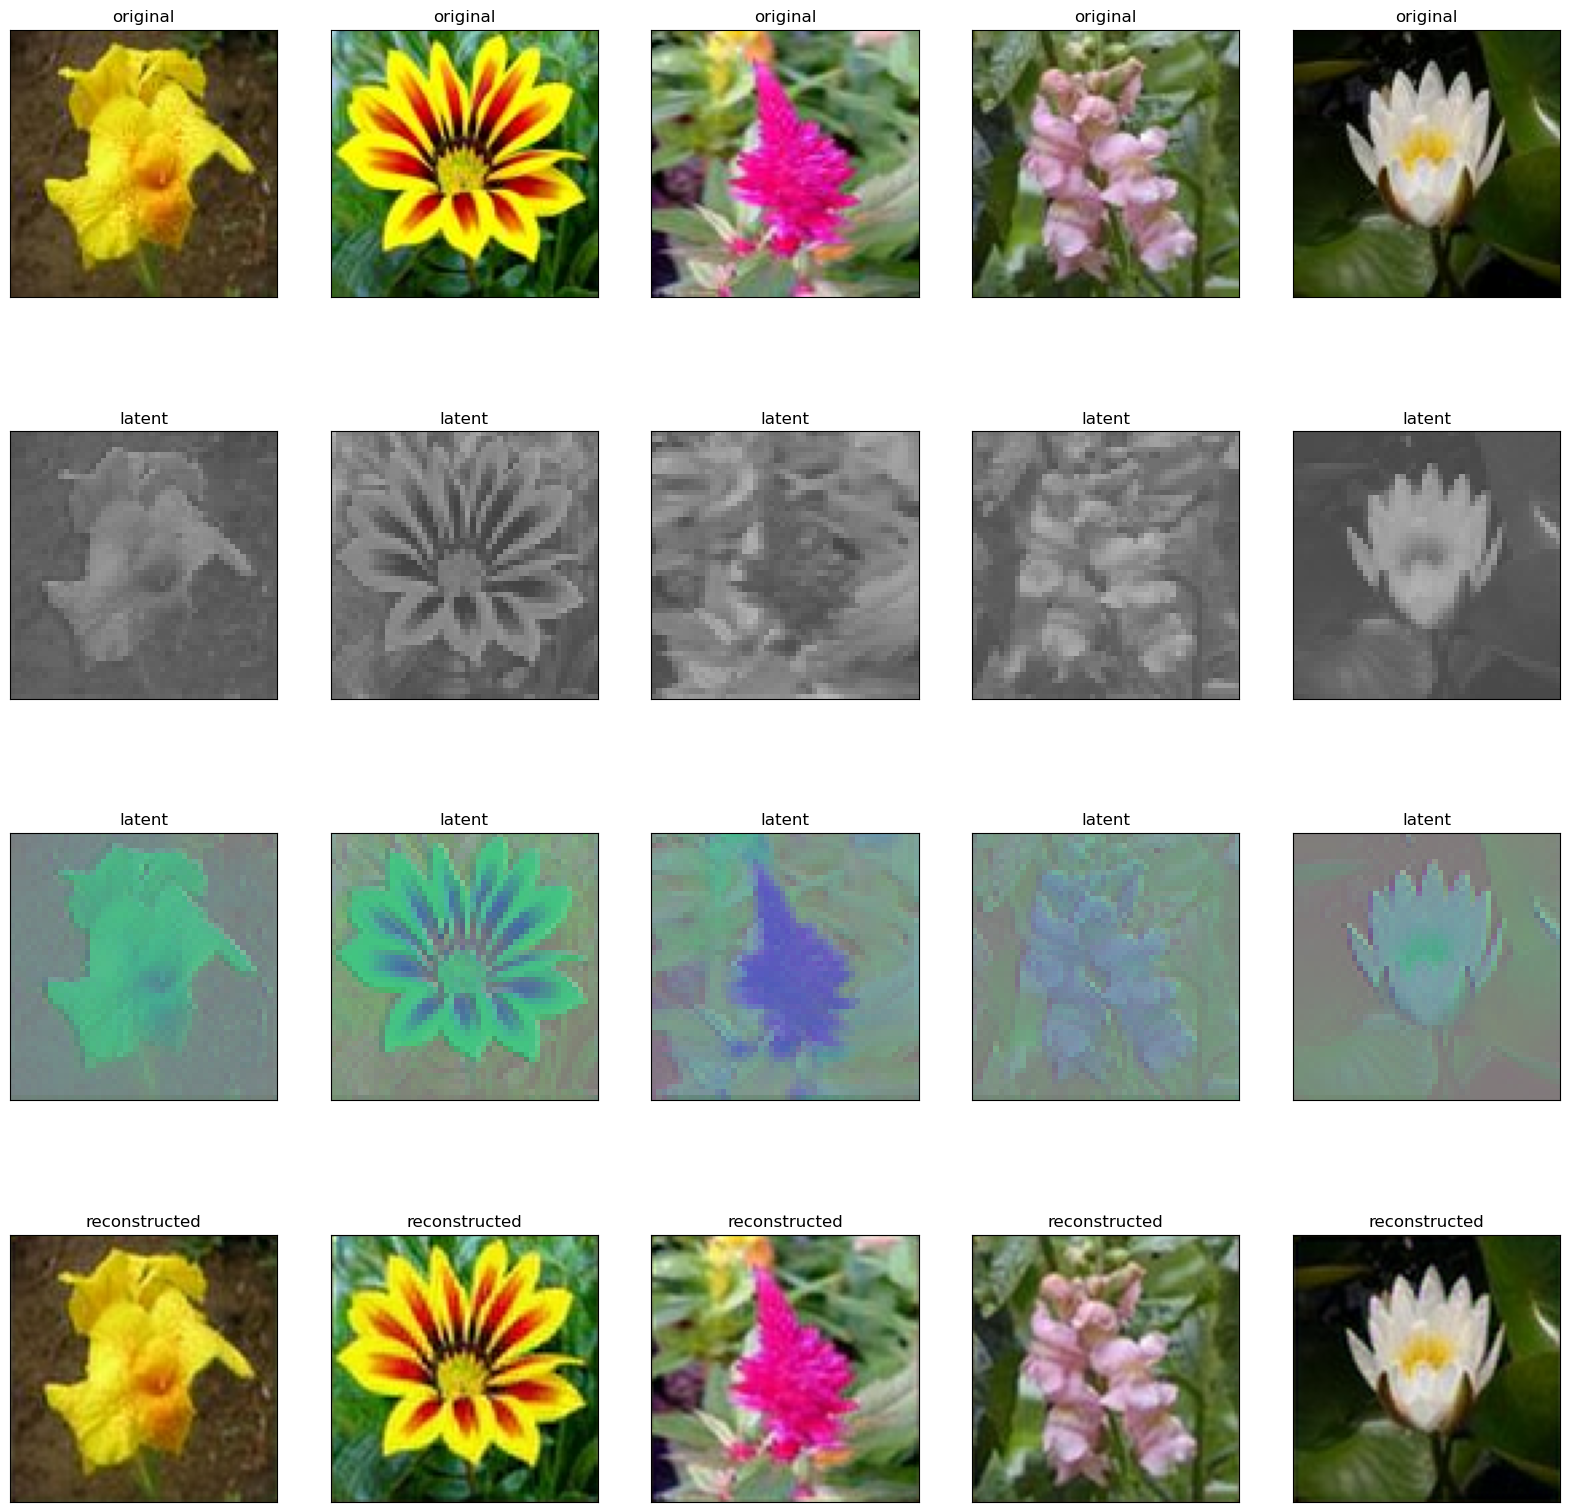

In [14]:
alex.printSamples(model_BW_RGB_50,batch[0:5],5,[(50,50,1),(50,50,3)])

In [15]:
output_csv = ["bn-rgb-50_results.csv","bn-rgb-25_results.csv"]  # Path to the output CSV file
data=None
for inx,x in enumerate(output_csv):
    if inx==0:
        data = pd.read_csv(x)
    else:
        data=pd.concat([data, pd.read_csv(x)], ignore_index=True)


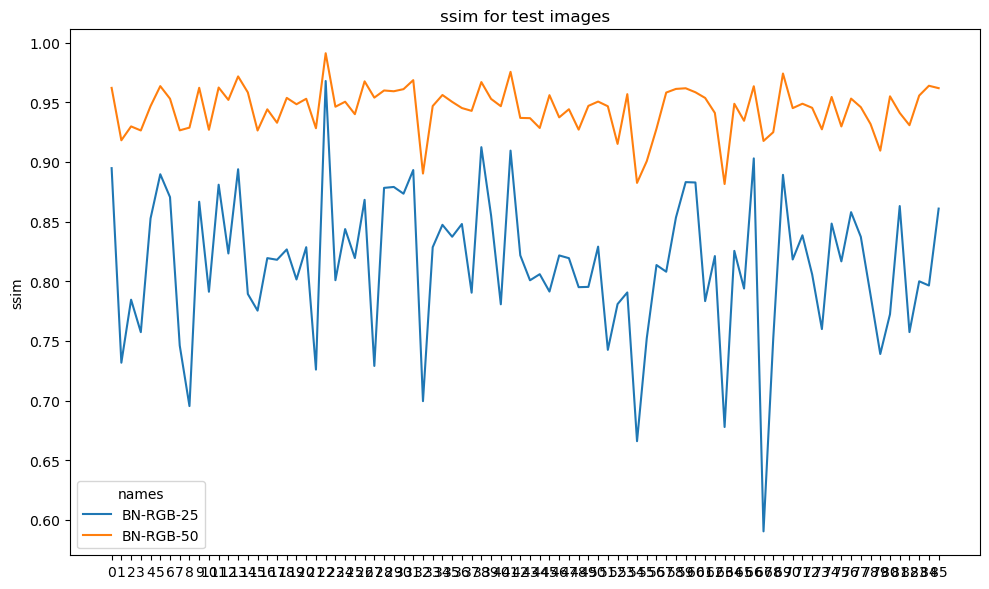

In [16]:
alex.ssimGraph(data)

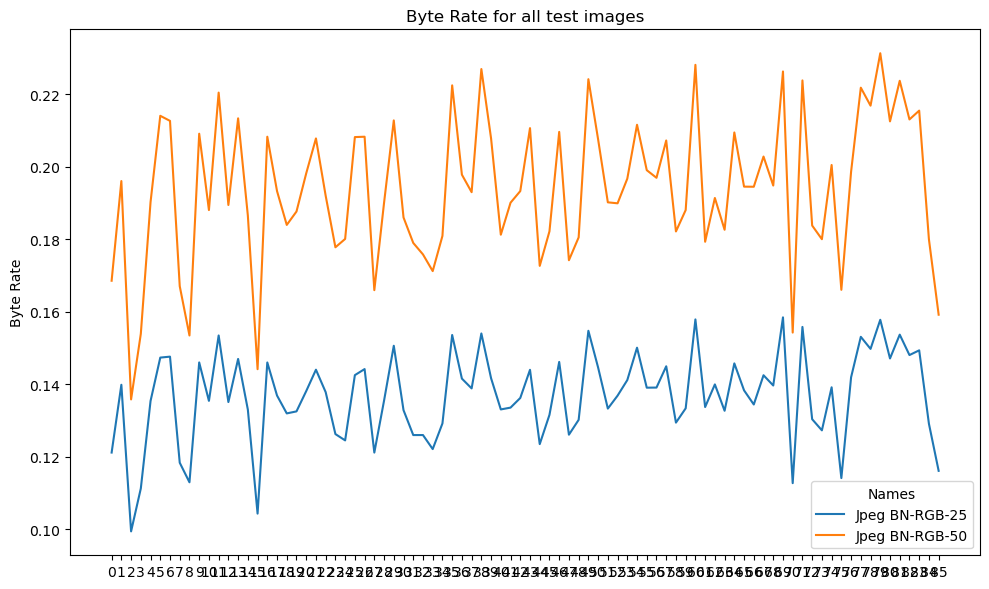

In [17]:
alex.rateGraph(data)

## 3.2 Modello RGB
Questo modello, meno ambizioso rispetto al precedente, si concentra esclusivamente su operazioni di **downscaling** e **upscaling**, sfruttando il maggior numero possibile di filtri e funzioni di attivazione.  

### Struttura del modello
L'encoder genera un'unica immagine residua con dimensioni $50 \times 50 \times 3$. Poiché l'approccio si basa sull'**upscaling**, è importante non ridurre troppo le dimensioni dell'immagine: in caso contrario, diventerebbe difficile ricostruirla correttamente senza incorrere in problemi di **overfitting**, portando a risultati inferiori.
Rispetto al modello precedente ha delle prestazioni inferiori.  

### Risultati e struttura
Come per il modello precedente, elenco di seguito la struttura del modello e i grafici relativi ai risultati ottenuti.  


In [18]:
model_RGB_50=modelli.AutoencoderFinalRGB(modelli.AutoencoderRGB())
model_RGB_50(batch[:5])
model_RGB_50.load_weights('modelli/RGB-25-RETRAIN.h5')

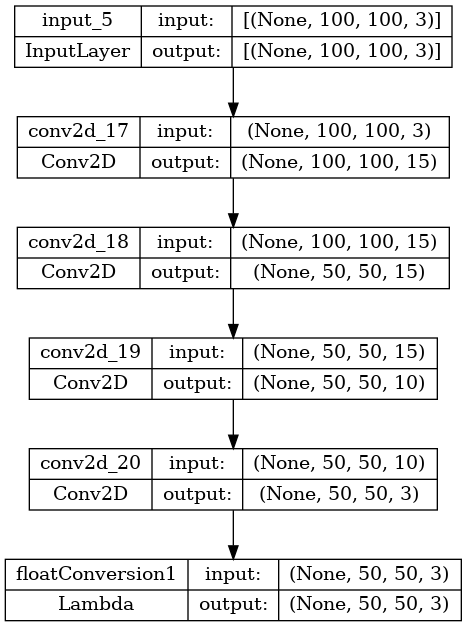

In [19]:
tf.keras.utils.plot_model(model_RGB_50.encoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)


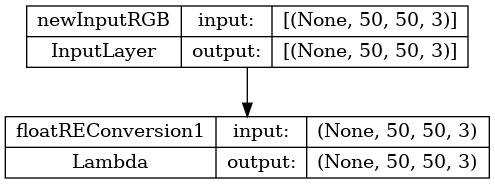

In [20]:
tf.keras.utils.plot_model(model_RGB_50.converter, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)


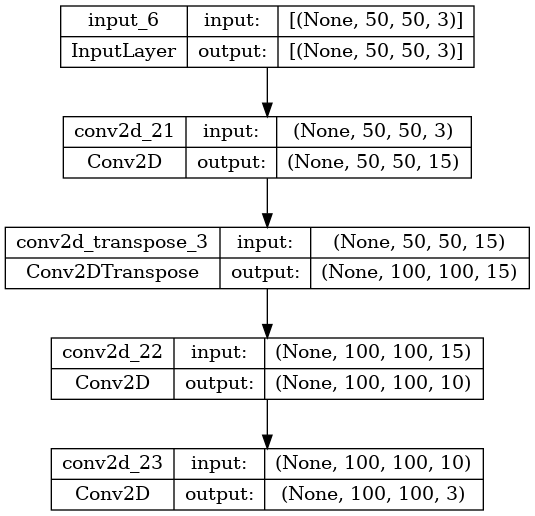

In [21]:
tf.keras.utils.plot_model(model_RGB_50.decoder, "multi_input_and_output_model.png", expand_nested=True,show_shapes=True)


![RGB MODEL sample](utilsImage/rgbmodel.png)


In [22]:
output_csv = ["rgb-50_results.csv"]  # Path to the output CSV file
data=None
for inx,x in enumerate(output_csv):
    if inx==0:
        data = pd.read_csv(x)
    else:
        data=pd.concat([data, pd.read_csv(x)], ignore_index=True)

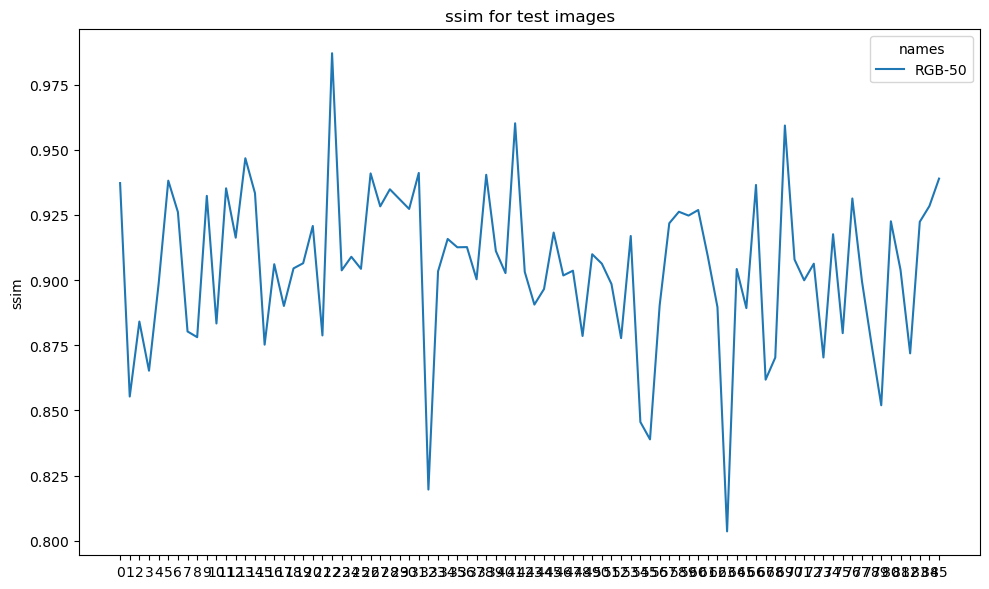

In [23]:
alex.ssimGraph(data)

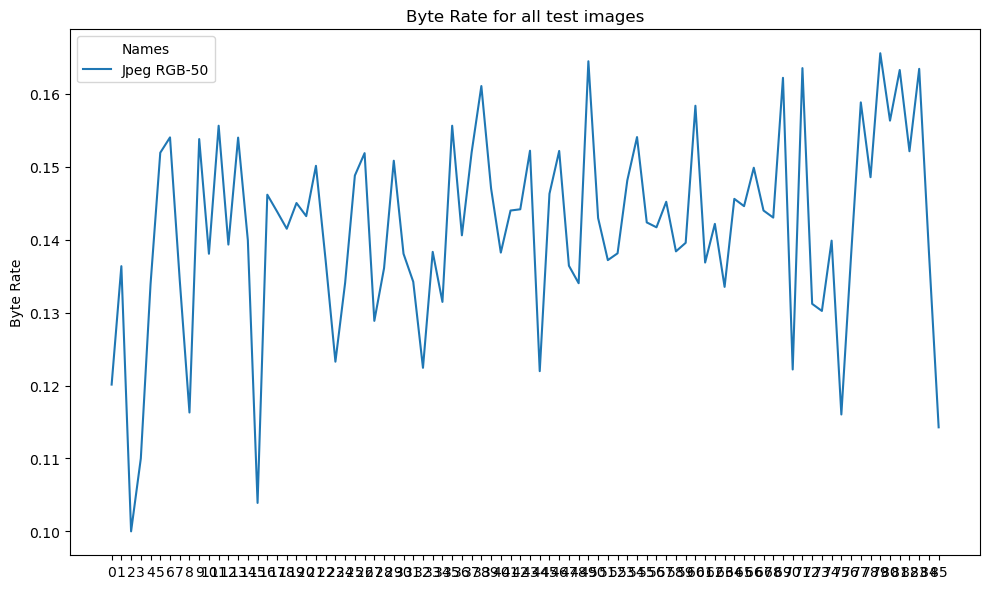

In [24]:
alex.rateGraph(data)

# 4.  Risultati 
Prima di fare una valutazione finale dei risultati vorrei illustrare i risultati che JPEG ha ottenuto con la qualita impostata ai seguenti valori:10, 50,70, 90.

In [25]:
output_csv = ["compression_results.csv"]  # Path to the output CSV file
data=None
for inx,x in enumerate(output_csv):
    if inx==0:
        data = pd.read_csv(x)
    else:
        data=pd.concat([data, pd.read_csv(x)], ignore_index=True)


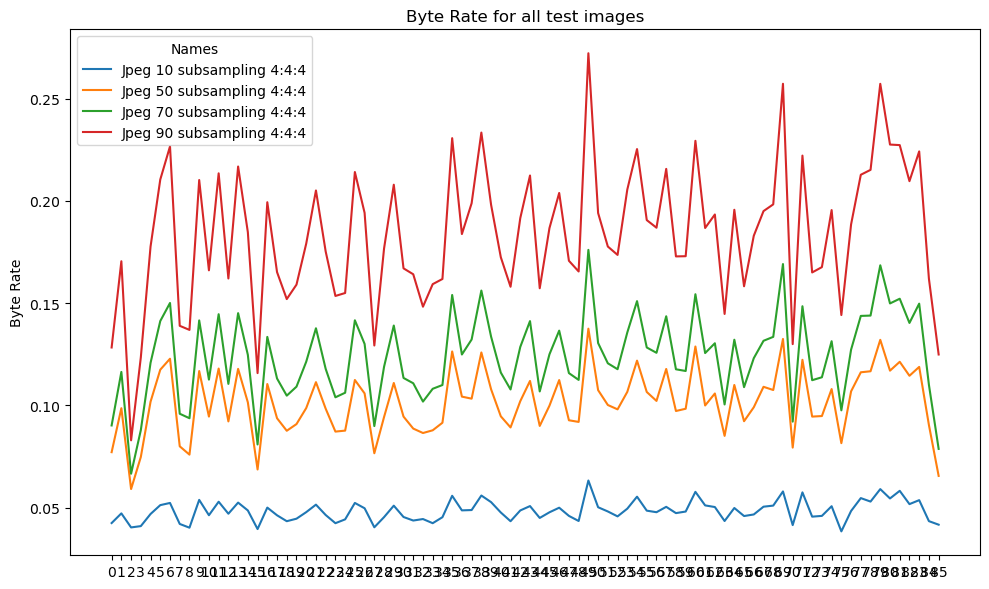

In [26]:
alex.rateGraph(data)

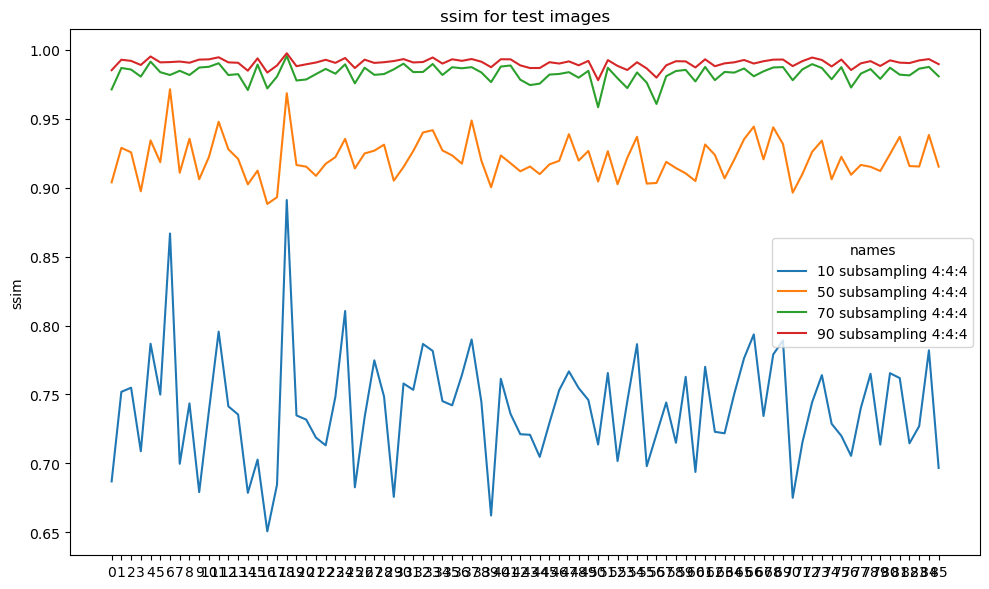

In [27]:
alex.ssimGraph(data)

### Comparazione dei risultati
Infine, per confrontare tutti i risultati ottenuti, presento il seguente grafico. Esso mostra ogni modello rispetto alle sue medie di **SSIM** e **byte rate**: 

In [28]:
output_csv = ["compression_results.csv","bn-rgb-50_results.csv","bn-rgb-25_results.csv","rgb-50_results.csv"]  # Path to the output CSV file
data=None
for inx,x in enumerate(output_csv):
    if inx==0:
        data = pd.read_csv(x)
    else:
        data=pd.concat([data, pd.read_csv(x)], ignore_index=True)


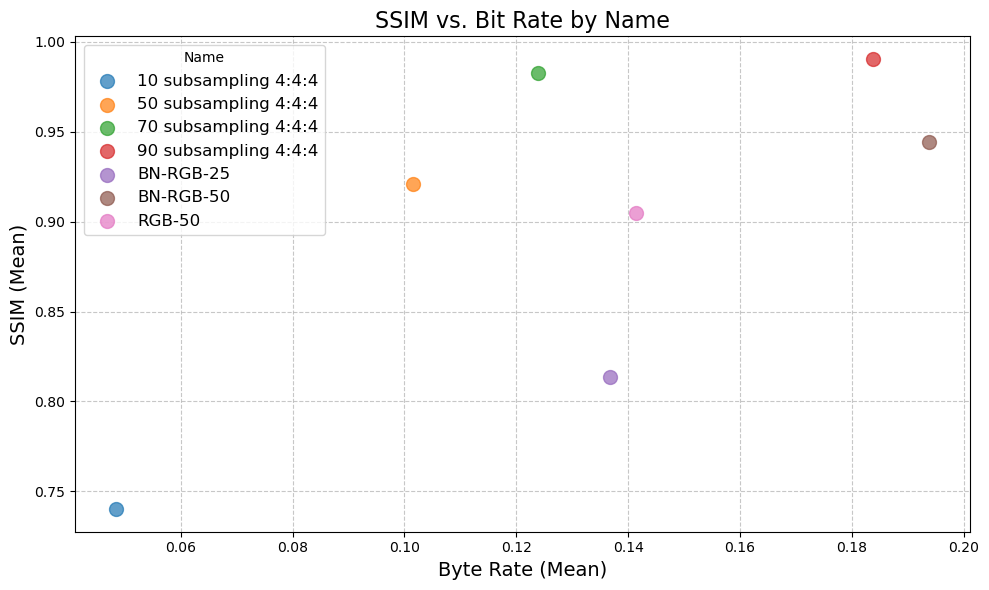

In [29]:
alex.printScatter(data)


Dal grafico si evince che nessuno dei modelli riesce a performare meglio di **JPEG**. Tuttavia, **BN-RGB-50** e **RGB-50** mostrano risultati accettabili, pur soffrendo rispettivamente di un byte rate troppo alto e di una SSIM troppo bassa. Sinceramente, mi aspettavo un risultato del genere: modelli così semplici difficilmente possono battere JPEG. Tuttavia, ci sono alcune considerazioni da fare:

- **Conversione a tensori interi senza JPEG**  
  Se rimuoviamo il meccanismo di conversione a JPEG e manteniamo solo la conversione a tensori interi, la **SSIM** non viene influenzata. Tuttavia, il numero di byte per pixel aumenta. In particolare, per il caso di **BN-RGB-50**, il valore diventa $\approx 0.5$, senza fluttuazioni dovute a JPEG. Questo permette di ottenere una compressione fissa che dimezza il peso delle immagini, mantenendo una SSIM $\approx 0.93$. Questo risultato potrebbe essere utile in applicazioni che richiedono una dimensione fissa delle immagini.

- **Utilizzo di JPEG 90 per il residuo**  
  Ho provato a utilizzare **JPEG 90** per la compressione del residuo, ottenendo abbassamenti drastici del byte rate. Questo potrebbe rendere i miei modelli migliori di JPEG, ma al costo di una penalizzazione significativa dell'integrità strutturale delle immagini.  
  Per ridurre questa penalità, ho effettuato nuovi round di training in cui l'input del decoder era la decompressione delle immagini con **JPEG 90**. Tuttavia, senza modificare il modello in modo significativo per ricostruire il residuo compresso e riportarlo a quello originale, non sono riuscito a ottenere risultati soddisfacenti.  
  (Uno dei modelli tentati è presente nella cartella **models**).

Concludo con un batch di 5 immagini prese dal test set date in pasto ad ogni modello o versione utilizzata di jpeg.

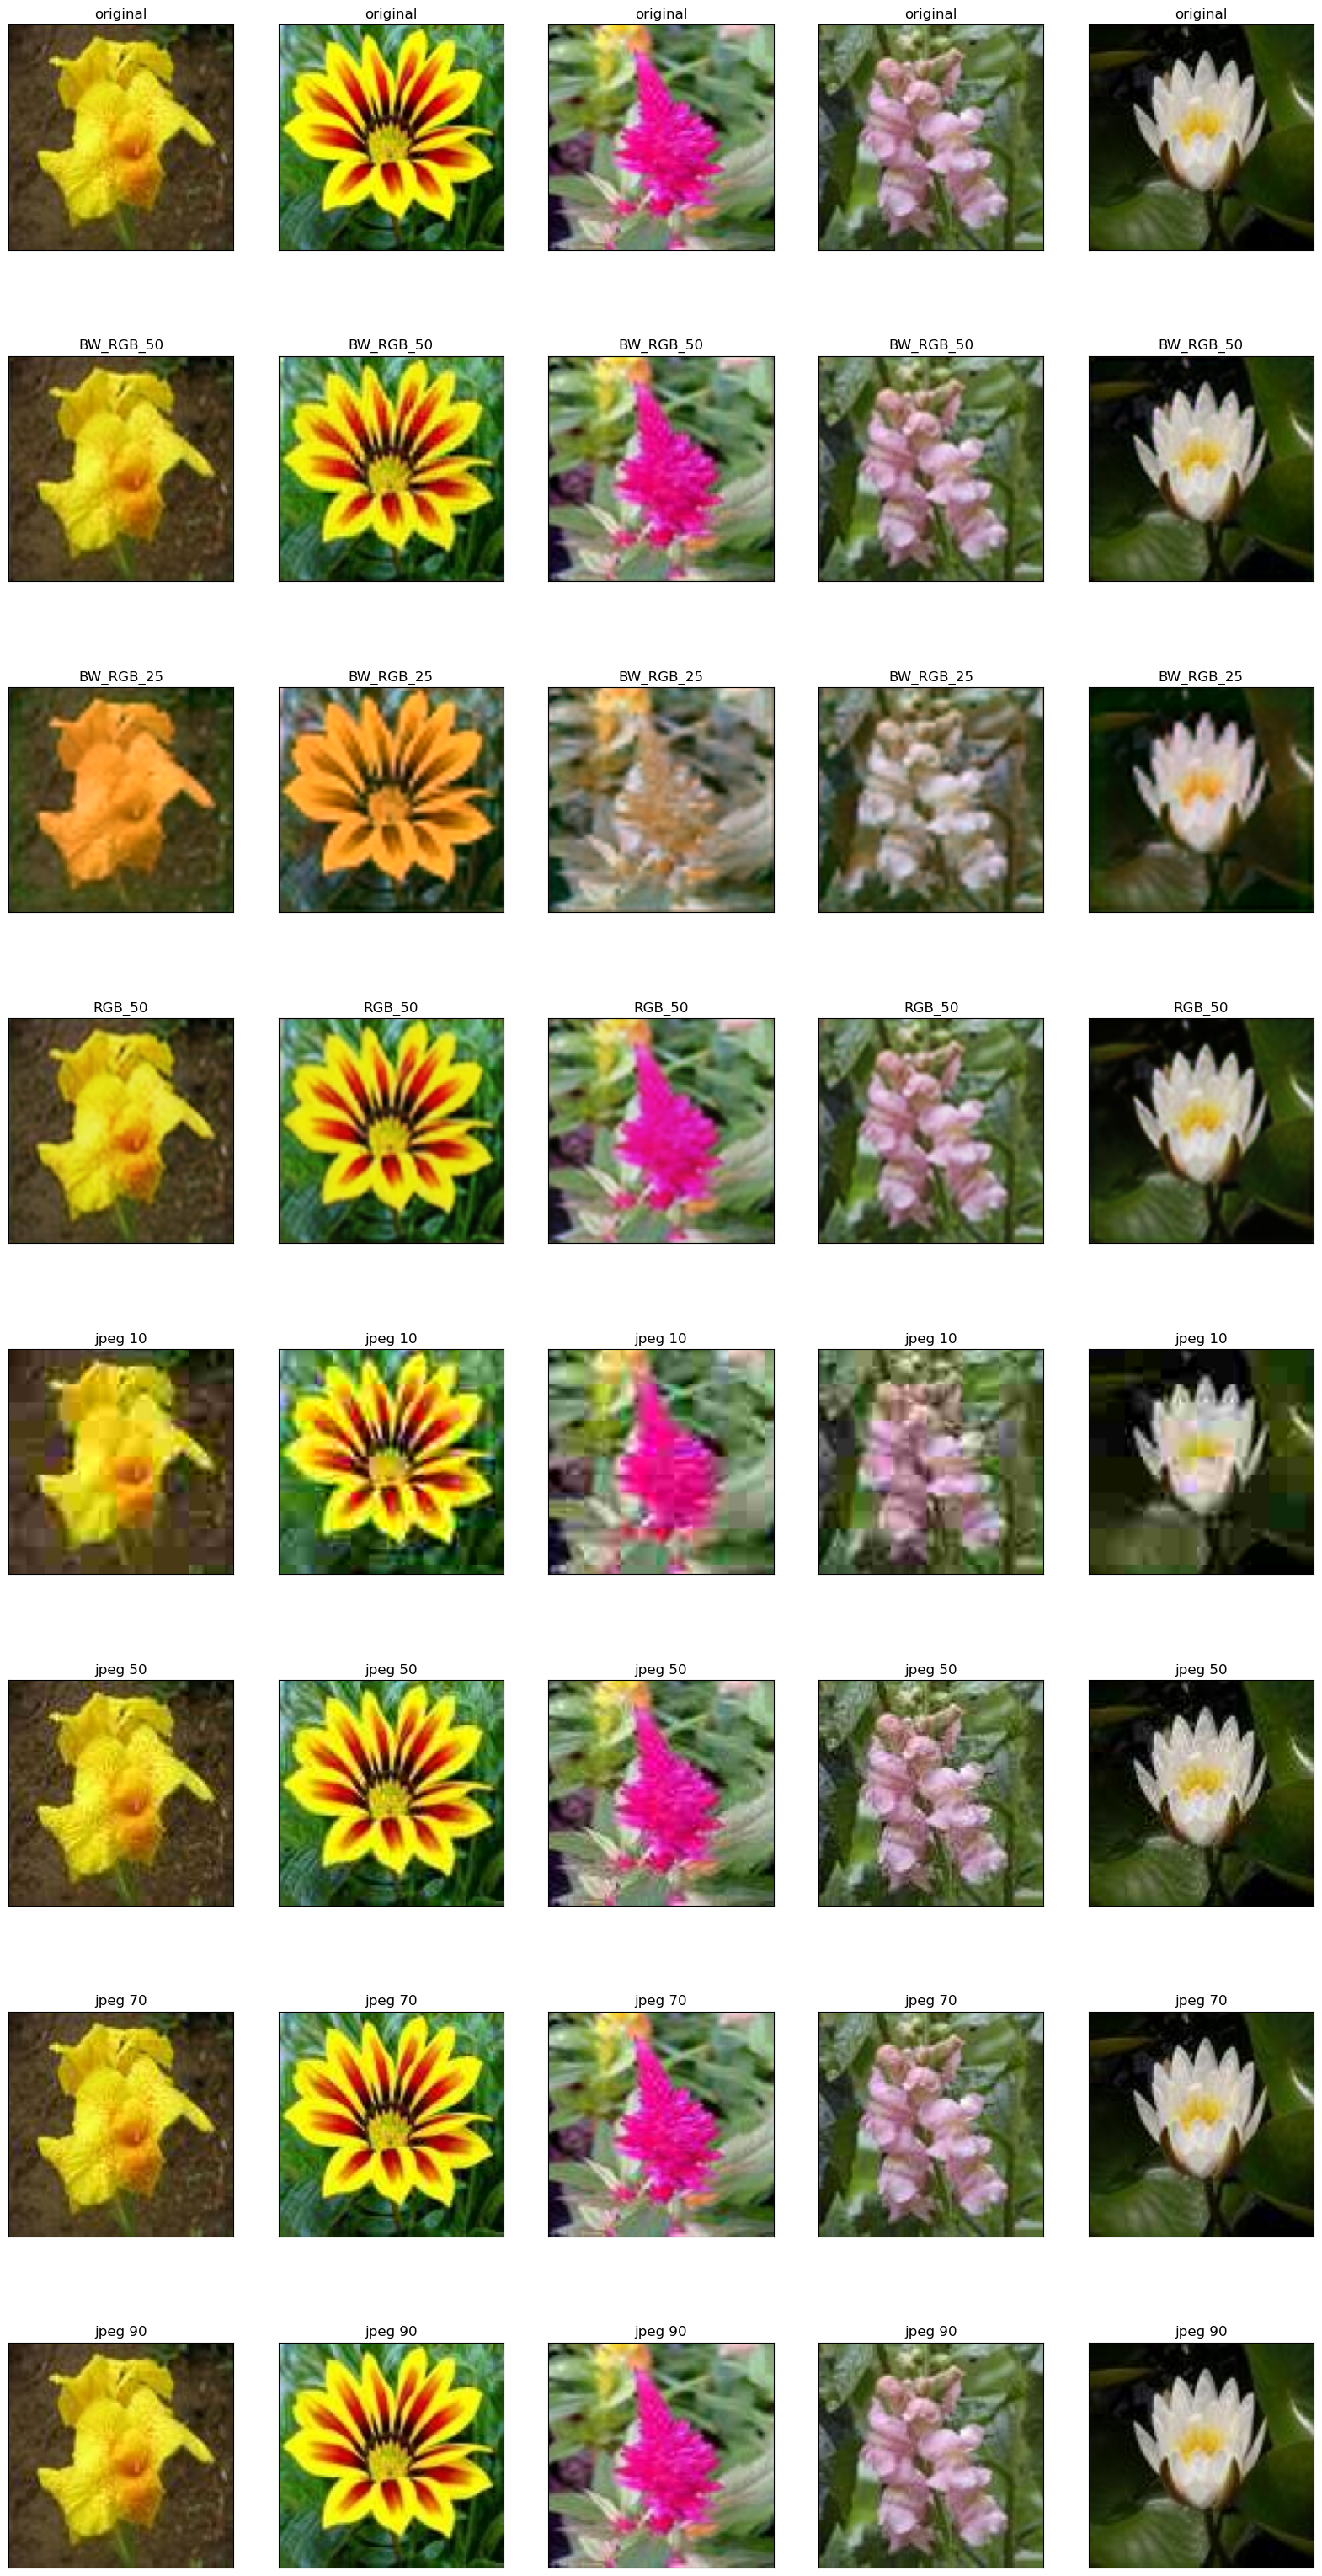

In [30]:
result=alex.prepareImagesOfAllModels([model_BW_RGB_50,model_BW_RGB_25,model_RGB_50],batch[0:5])
alex.printAllDec(batch[0:5],["BW_RGB_50","BW_RGB_25","RGB_50"],result)